In [76]:
import os
from numpy import genfromtxt
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from scipy.signal import resample

from data_organizer_Kfall import DataOrganizer
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [93]:
# mac
#sensor_data_folder = '/Users/liuxinqing/Documents/Kfall/sensor_data'  # Update with the path to sensor data
#label_data_folder = '/Users/liuxinqing/Documents/Kfall/label_data'  
# windows 
sensor_data_folder = 'G:\MLonMCU\Kfall_dataset\sensor_data'  # Update with the path to sensor data
label_data_folder = 'G:\MLonMCU\Kfall_dataset\label_data' 

#window_size = 256
# Kfall: window_size = 50
window_size = 50
threshold = 0.1
num_window_fall_data = 50
num_window_not_fall_data = 3

data, label = DataOrganizer(sensor_data_folder, 
                            label_data_folder, 
                            window_size, 
                            threshold, 
                            num_window_fall_data, 
                            num_window_not_fall_data)

Processing 1/32 folder...
Processing 2/32 folder...
Processing 3/32 folder...
Processing 4/32 folder...
Processing 5/32 folder...
Processing 6/32 folder...
Processing 7/32 folder...
Processing 8/32 folder...
Processing 9/32 folder...
Processing 10/32 folder...
Processing 11/32 folder...
Processing 12/32 folder...
Processing 13/32 folder...
Processing 14/32 folder...
Processing 15/32 folder...
Processing 16/32 folder...
Processing 17/32 folder...
Processing 18/32 folder...
Processing 19/32 folder...
Processing 20/32 folder...
Processing 21/32 folder...
Processing 22/32 folder...
Processing 23/32 folder...
Processing 24/32 folder...
Processing 25/32 folder...
Processing 26/32 folder...
Processing 27/32 folder...
Processing 28/32 folder...
Processing 29/32 folder...
Processing 30/32 folder...
Processing 31/32 folder...
Processing 32/32 folder...


In [94]:

# faltten the data

#data = data.reshape(data.shape[0], -1)
reshaped_data = data
in_channels = reshaped_data.shape[1]
print('in_channels: ', in_channels)
# the input data should have the shape (batch_size, in_channels, sequence_length)
#data = data.reshape(data.shape[0], in_channels, -1)
print('data.shape: ', reshaped_data.shape)

in_channels:  50
data.shape:  (15770, 50, 9)


In [95]:
# create a validate set

# create test/validation/test data
""" X_train, X_test, y_train, y_test = train_test_split(reshaped_data, 
                                                    label, 
                                                    test_size=0.2, 
                                                    random_state=42) """
label = label.astype(np.int64)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reshaped_data, label, test_size=0.05, random_state=42)

# Further split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#print(np.unique(y_train)) # [0 1]
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)


# select the test data that is not zero
X_test_true = X_test[y_test != 0]
y_test_true = y_test[y_test != 0]
# length of the test data
test_len = X_test_true.shape[0]
X_test_false = X_test[y_test == 0]
y_test_false = y_test[y_test == 0]
# X_test.shape:  (17, 50, 9)
# randomly len number of test data that is zero
index = np.random.choice(X_test_false.shape[0], test_len, replace=False)
# X_test.shape:  (17, 50, 9)
# randomly len number of test data that is zero
#index = np.random.choice(X_test_false.shape[0], len, replace=False)


X_test_false = X_test[index]
y_test_false = y_test[index]
#print('X_test_false.shape: ', X_test_false.shape)

#print('len(X_test): ', len)
#print('X_test.shape: ', X_test.shape)
#print('y_test.shape: ', y_test.shape)

# concatenate the true and false test data
X_test = np.concatenate((X_test_true, X_test_false), axis=0)
y_test = np.concatenate((y_test_true, y_test_false), axis=0)
#X_test = X_test[y_test != 0]
#y_test = y_test[y_test != 0]
print(X_test.shape)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train)
y_train_tensor = torch.from_numpy(y_train)
X_val_tensor = torch.from_numpy(X_val)
y_val_tensor = torch.from_numpy(y_val)
X_test_tensor = torch.from_numpy(X_test)
y_test_tensor = torch.from_numpy(y_test)


# print datatype of X_train_tensor
X_train_tensor = X_train_tensor.double()
print('X_train_tensor.dtype: ', X_train_tensor.dtype)
X_test = X_train_tensor.double()


# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

(56, 50, 9)
X_train_tensor.dtype:  torch.float64
Using cuda device


In [96]:
class ConvLSTM(nn.Module):
    def __init__(self):
        super(ConvLSTM, self).__init__()
        
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=9, out_channels=64, kernel_size=3, padding=1),
                                   nn.BatchNorm1d(64),
                                   nn.ReLU(),
                                   nn.MaxPool1d(2))
        self.conv2 = nn.Sequential(nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                   nn.BatchNorm1d(64),
                                   nn.ReLU(),
                                   nn.MaxPool1d(2))
        self.conv3 = nn.Sequential(nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
                                   nn.BatchNorm1d(64),
                                   nn.ReLU(),
                                   nn.MaxPool1d(2))

        # LSTM layers
        self.lstm1 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.dropout1 = nn.Dropout(0.5)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.dropout2 = nn.Dropout(0.5)

        self.fc = nn.Linear(64, 2)  # No need for softmax here using nn.CrossEntropyLoss
        #self.fc = nn.Sequential(nn.Linear(in_features=64, out_features=2),nn.Softmax())
    
    def forward(self, x):
        # Convolutional layers
        x = x.transpose(1, 2)  # Transpose to have the correct dimensions for Conv1d (batch, channels, length)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # Prepare for LSTM
        x = x.transpose(1, 2)  # Transpose back to (batch, seq_len, features)
        
        # LSTM layers
        x, _ = self.lstm1(x)  # Only take the output, ignore hidden states
        x = self.dropout1(x)
        x, _ = self.lstm2(x)  # Only take the output, ignore hidden states
        x = self.dropout2(x)
        
        # Take the outputs of the last time step
        x = x[:, -1, :]
        
        # Fully connected layer
        x = self.fc(x)
        # do i need softmax here?
        return x

In [97]:
#from models.ConvLSTM_KFall import ConvLSTM
# Create an instance of the model
model = ConvLSTM()

print(f"Model structure: {model}\n\n")
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: ConvLSTM(
  (conv1): Sequential(
    (0): Conv1d(9, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm1): LSTM(64, 64, batch_first=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (lstm2): LSTM(64, 64, batch_fir

In [98]:
# Hyperparameters
learning_rate = 5e-4
batch_size = 64
epochs = 50
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Initialize the scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, verbose=True)

In [99]:
""" # Implementation
def train_loop(dataloader, model, loss_fn, optimizer, patience=5):
    #print(dataloader.dataset)
    size = len(dataloader.dataset)
    # Set the model to training mode
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        #print('X.shape: ', X.shape)  # [64, 50, 9]
        # transpose X
        #X = X.transpose(1, 2)
        #print('transposed X.shape: ', X.shape)  # [64, 50, 9]
        B_size = (y_train == 0).sum()
        A_size = (y_train == 1).sum()
        #print('B_size: ', B_size)
        #print('A_size: ', A_size)
        B_multiplier = 1
        A_multiplier = B_size / A_size
        multipliers = torch.where(y == 0, B_multiplier, A_multiplier)
        pred = model(X.float())
        #loss = loss_fn(pred, y)
        loss = (loss_fn(pred, y) * multipliers).mean()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def val_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluate the model with torch.no_grad()
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluate the model with torch.no_grad()
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.float())
            print('pred: ', pred.argmax(1), 'y: ', y)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
 """

' # Implementation\ndef train_loop(dataloader, model, loss_fn, optimizer, patience=5):\n    #print(dataloader.dataset)\n    size = len(dataloader.dataset)\n    # Set the model to training mode\n    model.train()\n    for batch, (X, y) in enumerate(dataloader):\n        # Compute prediction and loss\n        #print(\'X.shape: \', X.shape)  # [64, 50, 9]\n        # transpose X\n        #X = X.transpose(1, 2)\n        #print(\'transposed X.shape: \', X.shape)  # [64, 50, 9]\n        B_size = (y_train == 0).sum()\n        A_size = (y_train == 1).sum()\n        #print(\'B_size: \', B_size)\n        #print(\'A_size: \', A_size)\n        B_multiplier = 1\n        A_multiplier = B_size / A_size\n        multipliers = torch.where(y == 0, B_multiplier, A_multiplier)\n        pred = model(X.float())\n        #loss = loss_fn(pred, y)\n        loss = (loss_fn(pred, y) * multipliers).mean()\n\n        # Backpropagation\n        loss.backward()\n        optimizer.step()\n        optimizer.zero_grad()

In [100]:
""" for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    val_loop(val_dataloader, model, loss_fn)
print("Done!") """

' for t in range(epochs):\n    print(f"Epoch {t+1}\n-------------------------------")\n    train_loop(train_dataloader, model, loss_fn, optimizer)\n    val_loop(val_dataloader, model, loss_fn)\nprint("Done!") '

In [101]:
def truth_test(_test,_pred, i):
    _test = np.array(_test)
    _pred = np.array(_pred)
    
    _pred_pos = _test[_pred == i]
    _pred_neg = _test[_pred != i]
    
    _true_pos = len(_pred_pos[_pred_pos == i])
    _fals_pos = len(_pred_pos[_pred_pos != i])
    
    _true_neg = len(_pred_neg[_pred_neg != i])
    _fals_neg = len(_pred_neg[_pred_neg == i])
    
    return _true_pos, _fals_pos, _true_neg, _fals_neg

def sensitivity(_test,_pred, i):
    tp, fp, tn, fn = truth_test(_test, _pred, i)
    return tp / ( tp + fn)

def specificity(_test,_pred, i):
    tp, fp, tn, fn = truth_test(_test, _pred, i)
    return tn / ( tn + fp)

def accuracy(_test, _pred, i):
    tp, fp, tn, fn = truth_test(_test, _pred, i)
    return (tp+tn) / (tp + fp + tn + fn)

In [102]:

def train_loop(dataloader, model, loss_fn, optimizer, val_dataloader, patience=5, scheduler=None):
    size = len(dataloader.dataset)
    model.train()
    best_val_loss = float('inf')
    no_improve_count = 0

    for epoch in range(epochs):
        print(f"Epoch {epoch}:")
        for batch, (X, y) in enumerate(dataloader):
            B_size = (y_train == 0).sum()
            A_size = (y_train == 1).sum()
            B_multiplier = 1
            A_multiplier = B_size / A_size
            multipliers = torch.where(y == 0, B_multiplier, A_multiplier)
            pred = model(X.float())
            loss = (loss_fn(pred, y) * multipliers).mean()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        val_loss = val_loop(val_dataloader, model, loss_fn)

        # Step the scheduler with the validation loss
        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_count = 0
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                print("Early stopping due to no improvement in validation loss.")
                break

def val_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.float())
            val_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= num_batches
    correct /= size
    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")
    
    return val_loss

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            y_true.extend(y.tolist())
            y_pred.extend(pred.argmax(1).tolist())

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    # Calculate accuracy, specificity, and sensitivity for each class
    # accuracy = (TP + TN) / (TP + TN + FP + FN)
    # Specificity = TN / (TN + FP)
    # Sensitivity = TP / (TP + FN)
    for i in range(2):  # Adjust the range depending on the number of classes
        print(" Label", i)
        print("    accuracy\t%5.3f"%accuracy(y_true, y_pred, i))
        print(" specificity\t%5.3f"%specificity(y_true, y_pred, i))
        print(" sensitivity\t%5.3f"%sensitivity(y_true, y_pred, i))

    # create a confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    # show the confusion matrix on a plot
    plt.matshow(cm)
    # add legend
    plt.colorbar()
    # add title
    plt.title('Confusion Matrix (0: not fall, 1: fall)')
 
  

In [103]:
train_loop(train_dataloader, model, loss_fn, optimizer,val_dataloader, patience=5, scheduler=scheduler)

Epoch 0:
loss: 1.536826  [   64/11984]


loss: 0.167088  [ 6464/11984]
Validation Error: 
 Accuracy: 95.8%, Avg loss: 0.095532 

Epoch 1:
loss: 0.070830  [   64/11984]
loss: 0.320696  [ 6464/11984]
Validation Error: 
 Accuracy: 96.3%, Avg loss: 0.086473 

Epoch 2:
loss: 0.350267  [   64/11984]
loss: 0.180156  [ 6464/11984]
Validation Error: 
 Accuracy: 96.3%, Avg loss: 0.078969 

Epoch 3:
loss: 0.048345  [   64/11984]
loss: 0.213142  [ 6464/11984]
Validation Error: 
 Accuracy: 96.5%, Avg loss: 0.075323 

Epoch 4:
loss: 0.144589  [   64/11984]
loss: 0.023312  [ 6464/11984]
Validation Error: 
 Accuracy: 97.0%, Avg loss: 0.070083 

Epoch 5:
loss: 0.043800  [   64/11984]
loss: 0.051276  [ 6464/11984]
Validation Error: 
 Accuracy: 97.4%, Avg loss: 0.070990 

Epoch 6:
loss: 0.102492  [   64/11984]
loss: 0.023714  [ 6464/11984]
Validation Error: 
 Accuracy: 97.5%, Avg loss: 0.064094 

Epoch 7:
loss: 0.023180  [   64/11984]
loss: 0.062944  [ 6464/11984]
Validation Error: 
 Accuracy: 97.6%, Avg loss: 0.060466 

Epoch 8:
loss: 0.049100

Test Error: 
 Accuracy: 98.2%, Avg loss: 0.068045 

 Label 0
    accuracy	0.982
 specificity	0.964
 sensitivity	1.000
 Label 1
    accuracy	0.982
 specificity	1.000
 sensitivity	0.964
[[28  0]
 [ 1 27]]


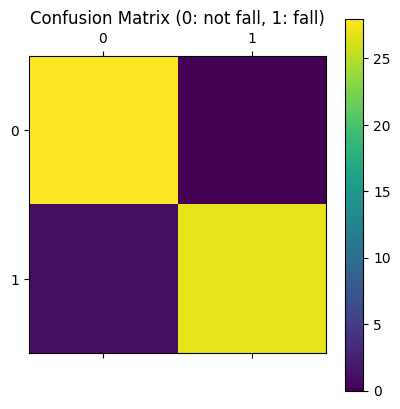

In [104]:
# final test

test_loop(test_dataloader, model, loss_fn)
